# Hedging With Options

If the strike percents are changed, change the regression in hedge_downside function and the headers in returned df

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

import patsy
import statsmodels.api as sm

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Get stock data

In [6]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
ex_stock='XOM'
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)

[*********************100%%**********************]  10 of 10 completed


In [7]:
# Option Pricing
def price_option(S0,vol,strike,risk_free_rate,expire,call=True):
        if call:
            option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Call, strike),
                         ql.EuropeanExercise(expire))
        else:
            option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Put, strike),
                         ql.EuropeanExercise(expire))
        u = ql.SimpleQuote(S0)      # set todays value of the underlying
        r = ql.SimpleQuote(risk_free_rate)       # set risk-free rate 
        sigma = ql.SimpleQuote(vol)   # set volatility
        riskFreeCurve = ql.FlatForward(0, ql.TARGET(), ql.QuoteHandle(r), ql.Actual360())
        volatility = ql.BlackConstantVol(0, ql.TARGET(), ql.QuoteHandle(sigma), ql.Actual360())
        # The Model
        process = ql.BlackScholesProcess( ql.QuoteHandle(u), 
                                       ql.YieldTermStructureHandle(riskFreeCurve),
                                       ql.BlackVolTermStructureHandle(volatility))
        engine = ql.AnalyticEuropeanEngine(process)
        # The Result
        option.setPricingEngine(engine)
        return option.NPV()

In [31]:
# Get df of option prices
def create_options(stock_df, stocks, strike_pcts,risk_free_rate, today,expire):
    """
    Returns price of 1 option on the stock 
    """
    dfs_to_concat = []
    ql.Settings.instance().evaluationDate = today
    for stock in stocks:
        S0 = stock_df[stock][-1]
        vol=returns_df.std()[ex_stock]*np.sqrt(252)
        
        strikes = [pct * S0 for pct in strike_pcts]
        #strikes = [S0*0.9, S0, S0*1.1]
        
        price_at_strike = []
        
        for strike in strikes:
            call = price_option(S0,vol,strike,risk_free_rate,expire,call=True)
            price_at_strike.append(call)
            put = price_option(S0,vol,strike,risk_free_rate,expire,call=False)
            price_at_strike.append(put)
        
        df_row = pd.DataFrame({
                'Ticker': [stock],
                'call_90_pct': [price_at_strike[0]],
                'call_atm': [price_at_strike[2]],
                'call_110_pct': [price_at_strike[4]],
                'put_90_pct': [price_at_strike[1]],
                'put_atm': [price_at_strike[3]],
                'put_110_pct': [price_at_strike[5]],
            })
            
        dfs_to_concat.append(df_row)
    
    output = pd.concat(dfs_to_concat, ignore_index=True)  
    return output

## Get option prices for tickers

In [32]:
tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100
today = ql.Date(19, 4, 2024)
expire = ql.Date(19, 4, 2025)
strike_pcts = [0.9, 1, 1.1]
create_options(stock_df, tickers, strike_pcts,risk_free_rate, today,expire)

,Ticker,call_90_pct,call_atm,call_110_pct,put_90_pct,put_atm,put_110_pct
0,XOM,19.815406,12.696875,7.623097,3.506119,7.744333,14.027300
1,FI,24.561943,15.738255,9.449116,4.345966,9.599392,17.387367
2,ATKR,28.619652,18.338264,11.010139,5.063933,11.185242,20.259814
3,VICI,4.601080,2.948178,1.770061,0.814111,1.798212,3.257098
4,STLD,22.749600,14.576982,8.751897,4.025292,8.891085,16.104412
5,GOOG,26.325802,16.868462,10.127682,4.658062,10.288751,18.636001
6,BN,6.450206,4.133020,2.481430,1.141293,2.520894,4.566092
7,BKNG,573.486480,367.465902,220.623431,101.472137,224.132176,405.970321
8,SBUX,14.570644,9.336253,5.605408,2.578116,5.694555,10.314540
9,NKE,16.006809,10.256487,6.157908,2.832229,6.255842,11.331199


## Get Portfolio Weights

In [33]:
returns_df=dat_func.get_log_returns(stock_df)
# vis.plot_cumulative_returns(returns_df)
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=1)
init_weights=init_weights.round(3)
weight_dict = dict(zip(returns_df.columns,init_weights))
# print('Initial Port Returns:',init_ret)
# print('Initial Port Volatility:',init_std)
# print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
# print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

## Hedging

In [43]:
def hedge_downside(stock_df, stocks, weights, strike_pcts):
    """
    Returns how many of each put you should but for $1 in the position, taking into account long/short 
    """
    option_list = []
    for stock in stocks:
        long = weight_dict[stock] >0.0  # If we are long the stock
        S0 = stock_df[stock][-1]
        
        gpc_gbm=dat_func.simulate_gbm(stock_df[stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
        
        if long:
            sim_min = np.min(gpc_gbm[:,-1])  # Get minimum value of stock from sim
            max_loss = round(sim_min - S0)
            loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
            stock_price = S0 + loss # stock prices for same loss
            portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})
        else:
            sim_max = np.max(gpc_gbm[:,-1])  # Get minimum value of stock from sim
            max_loss = round(S0 - sim_max)
            loss = np.linspace(0,max_loss,abs(max_loss)+1)  # max loss to 0 by 1
            stock_price = S0 - loss  # stock prices for same loss
            portfolio_value = pd.DataFrame({'stock':stock_price, 'loss':loss*-1})
            
        portfolio_value['put_atm'] = np.maximum(S0 - portfolio_value['stock'],0)
        portfolio_value['put_90_pct'] = np.maximum(S0 - portfolio_value['stock']*0.9,0)
        portfolio_value['put_110_pct'] = np.maximum(S0 - portfolio_value['stock']*1.1,0)
        portfolio_value['call_atm'] = np.maximum(portfolio_value['stock']-S0,0)
        portfolio_value['call_90_pct'] = np.maximum(portfolio_value['stock']*0.9 - S0,0)
        portfolio_value['call_110_pct'] = np.maximum(portfolio_value['stock']*1.1 - S0,0)
        
        y, X = patsy.dmatrices('loss ~ put_atm + put_90_pct + put_110_pct + call_atm + call_90_pct + call_110_pct', portfolio_value)
        linear_model = sm.OLS(y, X)
        results = linear_model.fit()
        option_list.append([stock] + list(results.params[1:]))
        
        if stock == 'XOM':
            port_val = portfolio_value.copy()
            port_val['put_atm'] = port_val['put_atm'] * results.params[1]
            port_val['put_90_pct'] = port_val['put_90_pct']* results.params[2]
            port_val['put_110_pct'] = port_val['put_110_pct'] * results.params[3]
            port_val['call_atm'] = port_val['call_atm'] * results.params[4]
            port_val['call_90_pct'] = port_val['call_90_pct'] * results.params[5]
            port_val['call_110_pct'] = port_val['call_110_pct'] * results.params[6]
            port_val['option_total'] = port_val['put_atm'] + port_val['put_90_pct'] + port_val['put_110_pct'] + port_val['call_atm']
            port_val['option_total'] = port_val['option_total'] + port_val['call_90_pct'] + port_val['call_110_pct']
            port_val['together'] = port_val['option_total'] + port_val['loss'] * -1
            plt.plot(port_val['stock'], port_val['loss'] * -1)
            plt.plot(port_val['stock'], port_val['option_total'])
            plt.plot(port_val['stock'], port_val['together'])
            plt.xlabel('Stock Price')
            plt.legend(['Stock Loss', 'Option Gain', 'together'])

    df = pd.DataFrame(option_list, columns=['Ticker', 'put_atm', 'put_90_pct', 'put_110_pct', 'call_atm', 'call_90_pct', 'call_110_pct'])
    
    return df

,Ticker,put_atm,put_90_pct,put_110_pct,call_atm,call_90_pct,call_110_pct
0,XOM,4.285006e-01,0.286139,0.285431,0.000000,0.000000,-0.285431
1,FI,4.285252e-01,0.285991,0.285530,0.000000,0.000000,-0.285530
2,ATKR,4.285374e-01,0.285919,0.285578,0.000000,0.000000,-0.285578
3,VICI,6.756273e-17,-0.275511,0.000000,0.424426,0.275511,0.297831
4,STLD,4.285176e-01,0.286037,0.285499,0.000000,0.000000,-0.285499
5,GOOG,4.285312e-01,0.285956,0.285553,0.000000,0.000000,-0.285553
6,BN,4.279293e-01,0.289567,0.283146,0.000000,0.000000,-0.283146
7,BKNG,4.285713e-01,0.285715,0.285714,0.000000,0.000000,-0.285714
8,SBUX,-1.968560e-18,-0.284607,0.000000,0.428122,0.284607,0.287029
9,NKE,-5.725368e-16,-0.284796,0.000000,0.428198,0.284796,0.286805


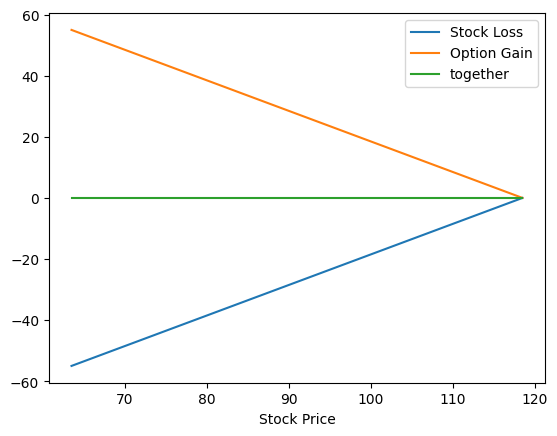

In [44]:
tickers = ['XOM','FI','ATKR','VICI','STLD','GOOG','BN','BKNG','SBUX','NKE']
strike_pcts = [0.9, 1, 1.1]
hedge_downside(stock_df, tickers, weight_dict, strike_pcts)